# Bayesian Missing Data Imputation

## Loading libraries

In [13]:
import random

import arviz as az
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.optimize
import pytensor.tensor as pt

from matplotlib.lines import Line2D
from pymc.sampling.jax import sample_blackjax_nuts, sample_numpyro_nuts
from scipy.stats import multivariate_normal

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

## Load data

In [2]:
try:
    df_employee = pd.read_csv("../data/employee.csv")
except FileNotFoundError:
    df_employee = pd.read_csv(pm.get_data("employee.csv"))
df_employee.head()

,employee,team,turnover,male,empower,lmx,worksat,climate,cohesion
0,1,1,0.0,1,32.0,11.0,3.0,18.0,3.5
1,2,1,1.0,1,NaN,13.0,4.0,18.0,3.5
2,3,1,1.0,1,30.0,9.0,4.0,18.0,3.5
3,4,1,1.0,1,29.0,8.0,3.0,18.0,3.5
4,5,1,1.0,0,26.0,7.0,4.0,18.0,3.5


## EDA

In [8]:
# % of NA´s
(df_employee[['worksat', 'empower', 'lmx']]
    .isna()
    .sum() / len(df_employee) * 100
)

worksat     4.761905
empower    16.190476
lmx         4.126984
dtype: float64

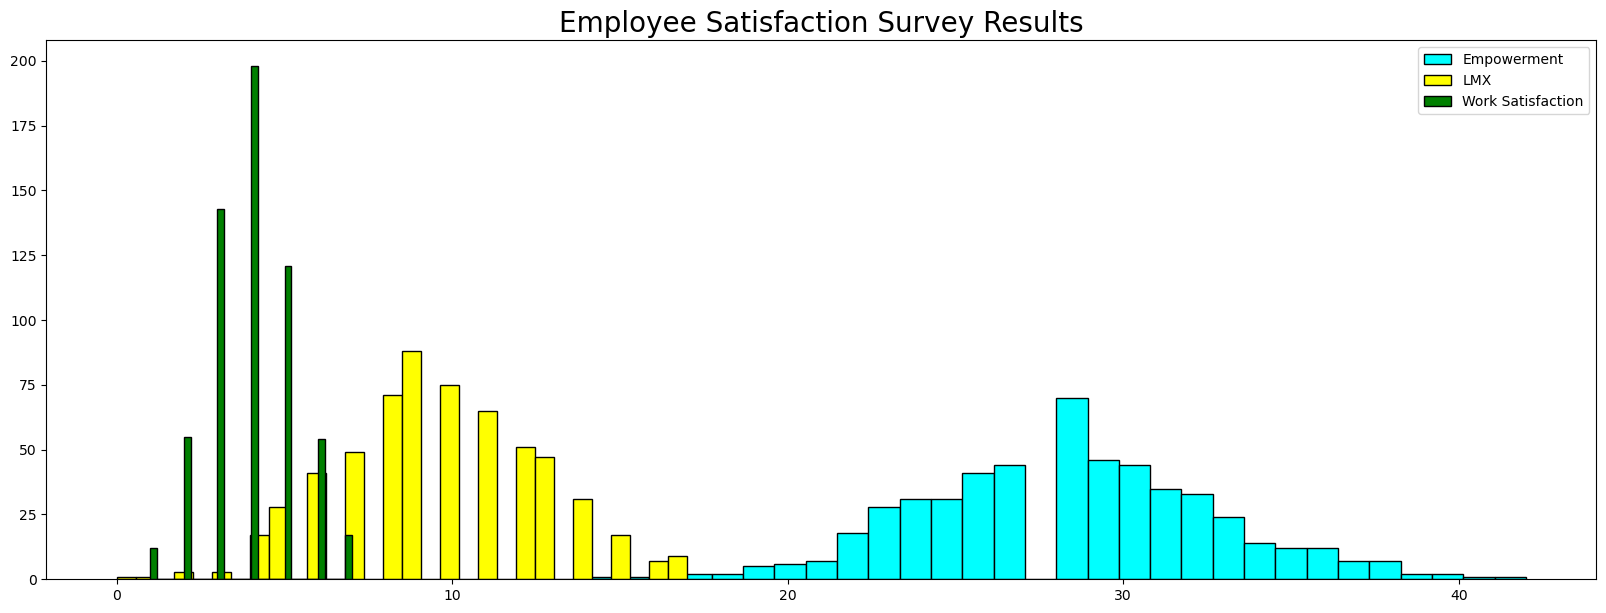

In [9]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.hist(df_employee["empower"], bins=30, ec="black", color="cyan", label="Empowerment")
ax.hist(df_employee["lmx"], bins=30, ec="black", color="yellow", label="LMX")
ax.hist(df_employee["worksat"], bins=30, ec="black", color="green", label="Work Satisfaction")
ax.set_title("Employee Satisfaction Survey Results", fontsize=20)
ax.legend();

## Bayesian imputation

In [15]:
with pm.Model() as model:
    # Prios
    mus = pm.Normal('mus', 0, 1, size = 3)
    cov_flat_prior, _, _ = pm.LKJCholeskyCov('cov', n = 3, eta = 1.0, sd_dist = pm.Exponential.dist(1))

    # Create a vector of flot variables for the unobserved components of the MvNormal
    x_unobs = pm.Uniform('x_unobs', 0, 100, shape = (np.isnan(data.values).sum(),))

    # Create a symbolic value of x, combining observed data and unobserved variables
    x = pt.as_tensor(data.values)
    x = pm.Deterministic('x', pt.set_subtensor(x[np.isnan(data.values)], x_unobs))

    # Add a Potential with the logp of the variable conditioned on 'x'
    pm.Potential('x_logp', pm.logp(rv = pm.MvNormal.dist(mus, chol = cov_flat_prior), value = x))

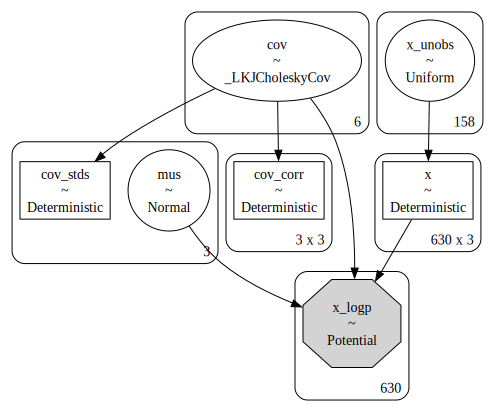

In [16]:
pm.model_to_graphviz(model)

In [17]:
with model:
    idata = pm.sample_prior_predictive()
    idata = pm.sample()
    idata.extend(pm.sample(random_seed = 120))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

C:\Users\bacos1\AppData\Local\Temp\ipykernel_5444\285228838.py:2: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [cov, mus, x_unobs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus, cov, x_unobs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus, cov, x_unobs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
C:\Users\bacos1\AppData\Local\Temp\ipykernel_5444\285228838.py:5: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pm.sample_posterior_predictive(idata, extend_inferencedata=True)


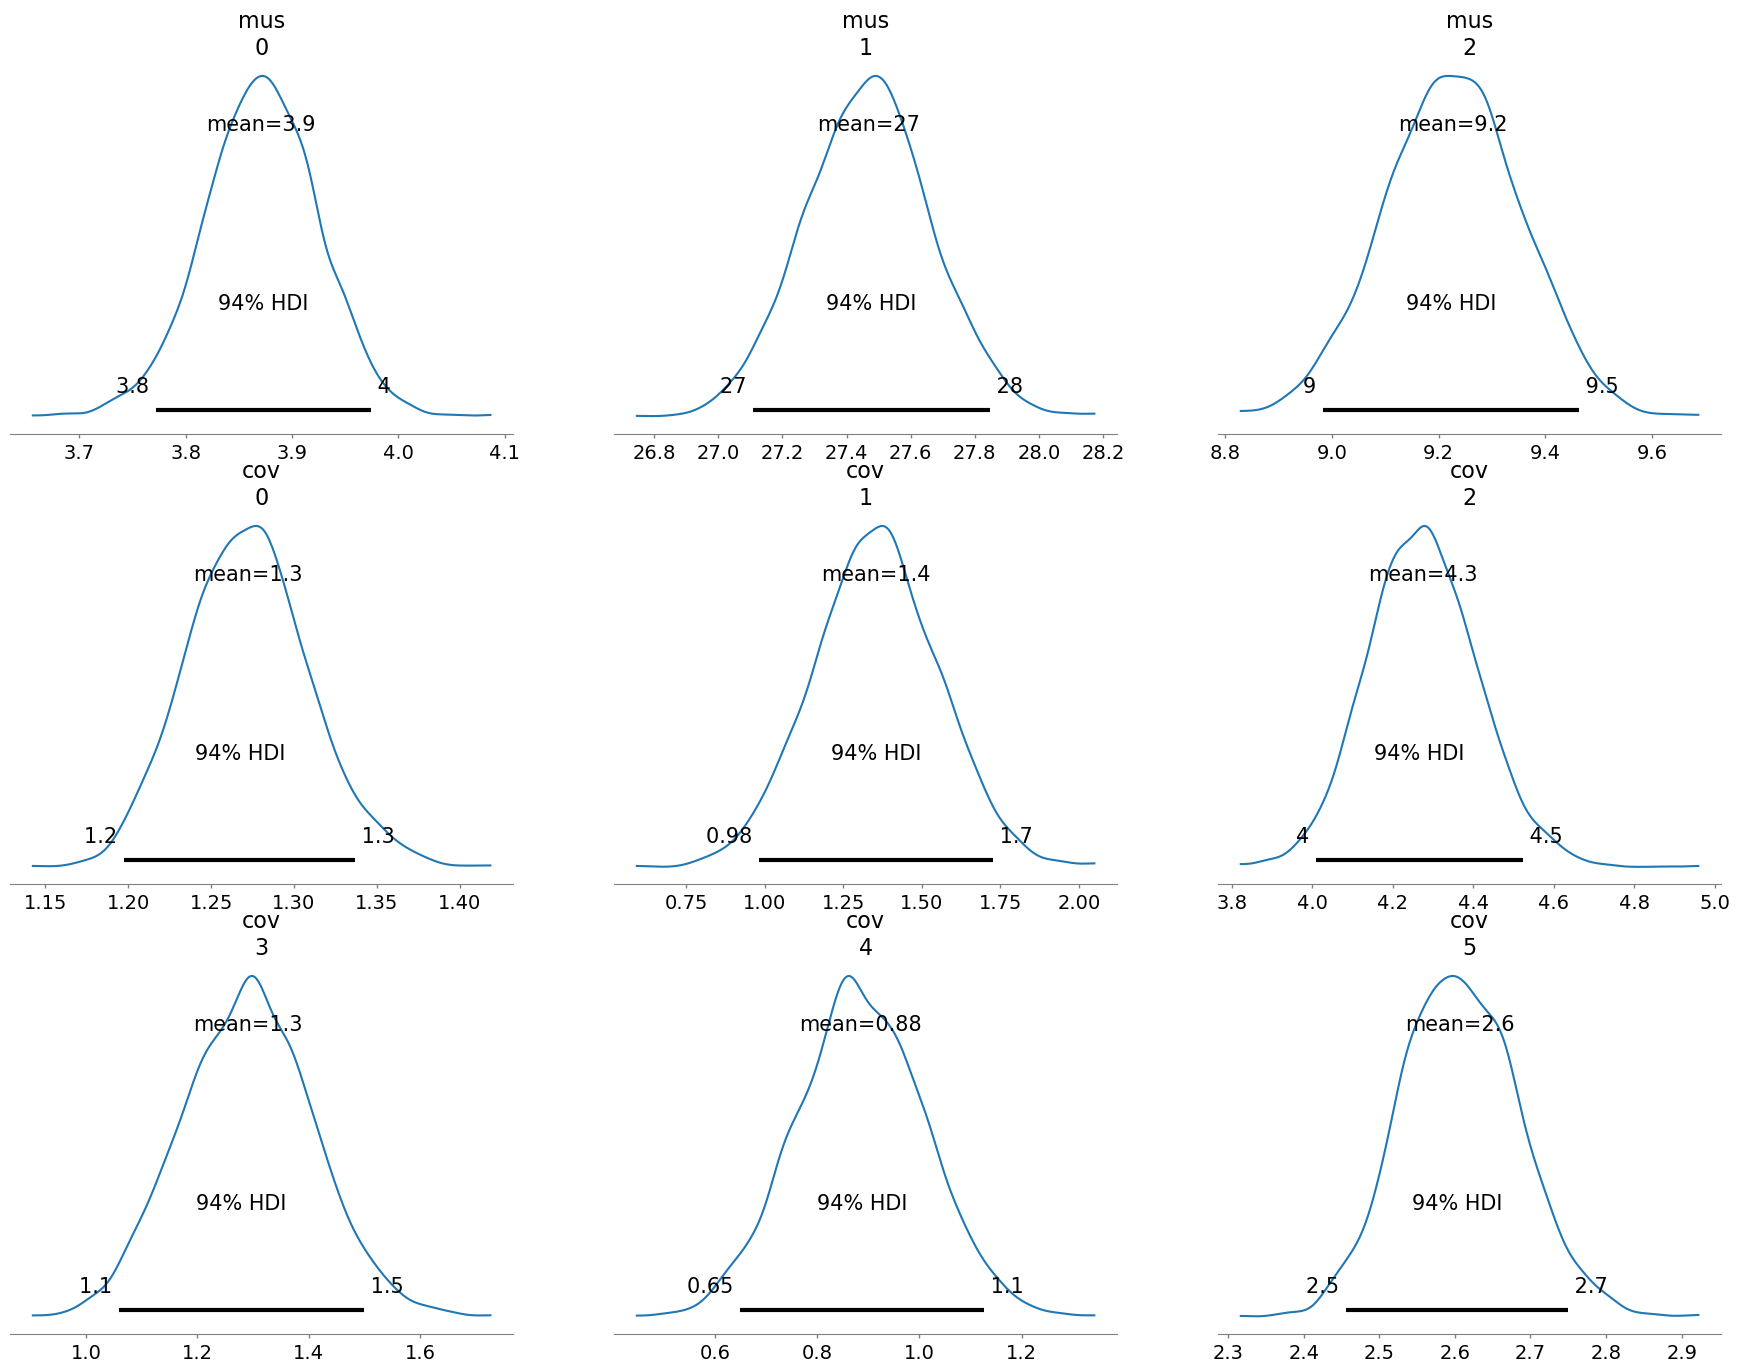

In [18]:
az.plot_posterior(idata, var_names=["mus", "cov"]);

In [19]:
az.summary(idata, var_names=["mus", "cov", "x_unobs"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mus[0],3.871,0.054,3.772,3.975,0.001,0.000,6012.0,3080.0,1.0
mus[1],27.468,0.197,27.108,27.848,0.003,0.002,6102.0,3273.0,1.0
mus[2],9.227,0.128,8.984,9.464,0.002,0.001,6330.0,3669.0,1.0
cov[0],1.272,0.037,1.198,1.337,0.000,0.000,6445.0,3310.0,1.0
cov[1],1.353,0.199,0.982,1.726,0.003,0.002,5705.0,3307.0,1.0
...,...,...,...,...,...,...,...,...,...
x_unobs[153],29.862,4.150,21.773,37.275,0.050,0.035,7000.0,2708.0,1.0
x_unobs[154],2.589,1.081,0.608,4.620,0.018,0.012,3482.0,1943.0,1.0
x_unobs[155],29.921,4.068,22.247,37.380,0.041,0.029,9847.0,2771.0,1.0
x_unobs[156],29.547,4.026,21.574,36.821,0.043,0.030,8821.0,2550.0,1.0


In [20]:
imputed_dims = data.shape
imputed = data.values.flatten()
imputed[np.isnan(imputed)] = az.summary(idata, var_names=["x_unobs"])["mean"].values
imputed = imputed.reshape(imputed_dims[0], imputed_dims[1])
imputed = pd.DataFrame(imputed, columns=[col + "_imputed" for col in data.columns])
imputed.head(10)

,worksat_imputed,empower_imputed,lmx_imputed
0,3.000,32.000,11.000
1,4.000,29.487,13.000
2,4.000,30.000,9.000
3,3.000,29.000,8.000
4,4.000,26.000,7.000
5,4.002,27.974,10.000
6,5.000,28.982,11.000
7,3.000,22.000,9.000
8,2.000,23.000,6.902
9,4.000,32.000,9.000


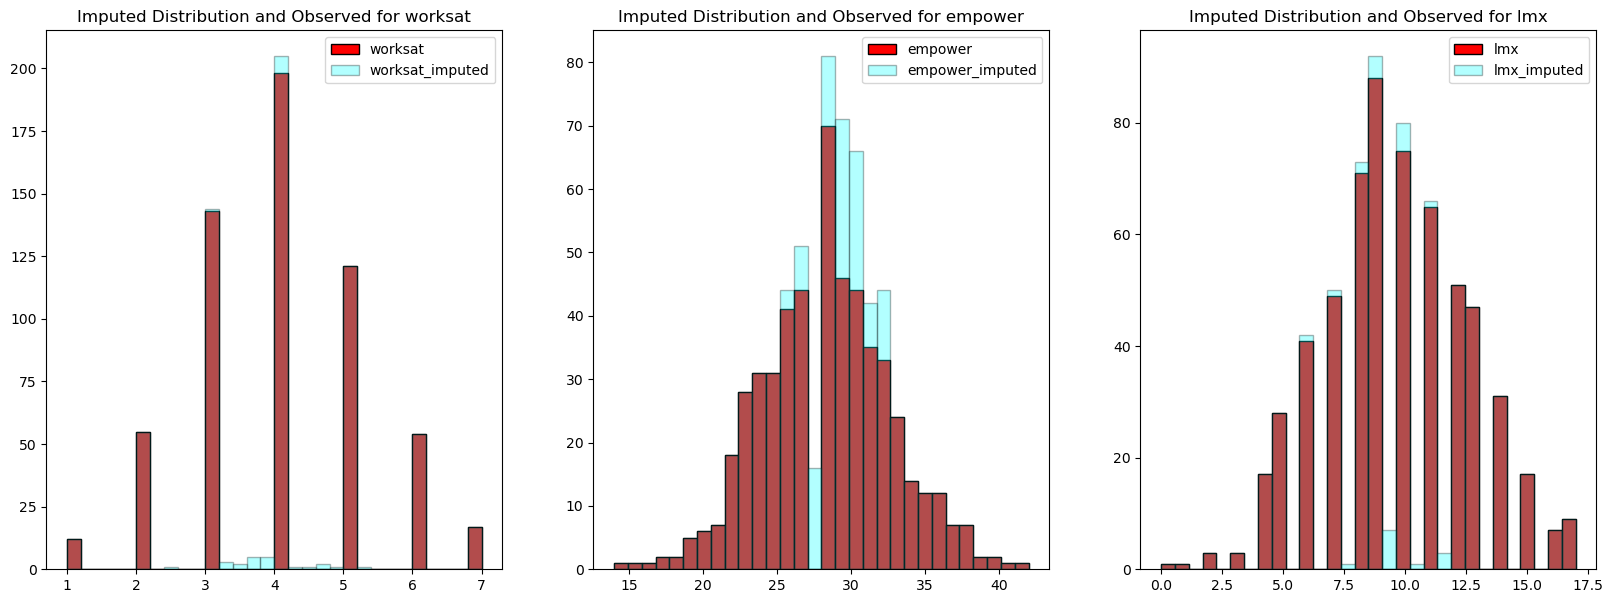

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
axs = axs.flatten()
for col, col_i, ax in zip(data.columns, imputed.columns, axs):
    ax.hist(data[col], color="red", label=col, ec="black", bins=30)
    ax.hist(imputed[col_i], color="cyan", alpha=0.3, label=col_i, ec="black", bins=30)
    ax.legend()
    ax.set_title(f"Imputed Distribution and Observed for {col}")

In [22]:
pd.DataFrame(az.summary(idata, var_names=["cov_corr"])["mean"].values.reshape(3, 3))

C:\Users\bacos1\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,0,1,2
0,1.000,0.301,0.424
1,0.301,1.000,0.405
2,0.424,0.405,1.000


## Bayesian imputation by chained equations

In [23]:
data = df_employee[["lmx", "empower", "climate", "male"]]

In [24]:
lmx_mean = data["lmx"].mean()
lmx_min = data["lmx"].min()
lmx_max = data["lmx"].max()
lmx_sd = data["lmx"].std()

In [25]:
cli_mean = data["climate"].mean()
cli_min = data["climate"].min()
cli_max = data["climate"].max()
cli_sd = data["climate"].std()

In [29]:
priors = {
    'climate': {'normal': [lmx_mean, lmx_sd, lmx_sd], 'uniform': [lmx_min, lmx_max]},
    'lmx': {'normal': [cli_mean, cli_sd, cli_sd], 'uniform': [cli_min, cli_max]}
}